<a href="https://colab.research.google.com/github/gio-bis/MLPNS2021/blob/main/Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import pandas as pd
import pylab as pl
import scipy as sp
from scipy import stats
%pylab inline

# I have created a stylesheet to define default plot behaviors. 
#This stylesheet changes the default parameters stored in the ictionary matplitlib.rcParams
pl.style.use("https://raw.githubusercontent.com/fedhere/MLPNS2021/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'ndim']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [75]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLPNS2021/main/HW3_LinearRegression/grb050525A.csv")

In [76]:
grbAG

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0
...,...,...,...,...,...
114,W1,63738,NaN,21.20,1
115,M2,74798,NaN,21.59,1
116,U,128928,NaN,20.05,1
117,V,971360,NaN,22.09,1


In [77]:
grbAG["logtime"]  = np.log10(grbAG["time"])

In [78]:
grbAG

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098
...,...,...,...,...,...,...
114,W1,63738,NaN,21.20,1,4.804398
115,M2,74798,NaN,21.59,1,4.873890
116,U,128928,NaN,20.05,1,5.110347
117,V,971360,NaN,22.09,1,5.987380


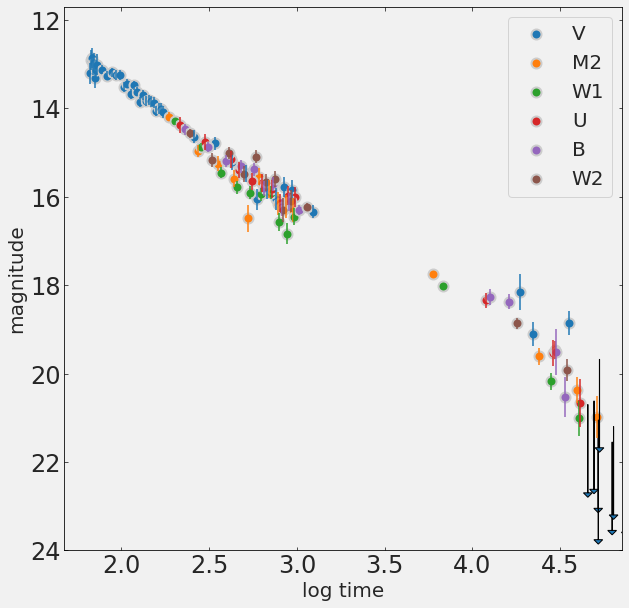

In [79]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
#loop on every filter to plot - this will give differnt colors naturally. 
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')
    

# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)          
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

In [80]:
x = grbAG[grbAG.upperlimit == 0].logtime
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)), x]
y = grbAG.loc[grbAG.upperlimit == 0].mag

In [81]:
X.shape

(108, 2)

In [82]:
y.shape

(108,)

In [83]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

In [84]:
print ("best fit parameters from the Normal Equation: intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


##Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

In [85]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X, y)
print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


##Fit a line to the data (excluding the upper limits) by minimizing an objective function

In [86]:
from scipy.optimize import minimize

def line(x, intercept, slope):
    return slope * x + intercept
def l1(args, x, y):
    a, b = args
    return sum(np.abs(y - line(a, b, x)))

initialGuess = (10, 1)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

      fun: 26.303691403868047
 hess_inv: array([[ 9.24535720e-05, -1.93740490e-04],
       [-1.93740490e-04,  1.19320831e-03]])
      jac: array([1.61817122, 0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 500
      nit: 12
     njev: 122
   status: 2
  success: False
        x: array([2.64056468, 8.22612169])

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


In [87]:
def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    a, b = args
    return sum((y - line(a, b, x))**2)


initialGuess = (10, 1)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

      fun: 12.825987500725471
 hess_inv: array([[ 0.00711354, -0.02029726],
       [-0.02029726,  0.06254437]])
      jac: array([8.34465027e-07, 1.19209290e-07])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([2.51199977, 8.58266841])

best fit parameters from the minimization of L2: slope 2.51, intercept 8.58


##Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [88]:
def chi2(args, x, y, s):
    a, b = args
    return sum((y - line(a, b, x))**2 / s**2)

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

      fun: 317.42066980131057
 hess_inv: array([[ 0.00020171, -0.00054289],
       [-0.00054289,  0.00155851]])
      jac: array([7.62939453e-06, 3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([2.48019101, 8.59948749])

best fit parameters from the minimization of the chi squared: slope 2.48, intercept 8.60


##Plot all the solutions

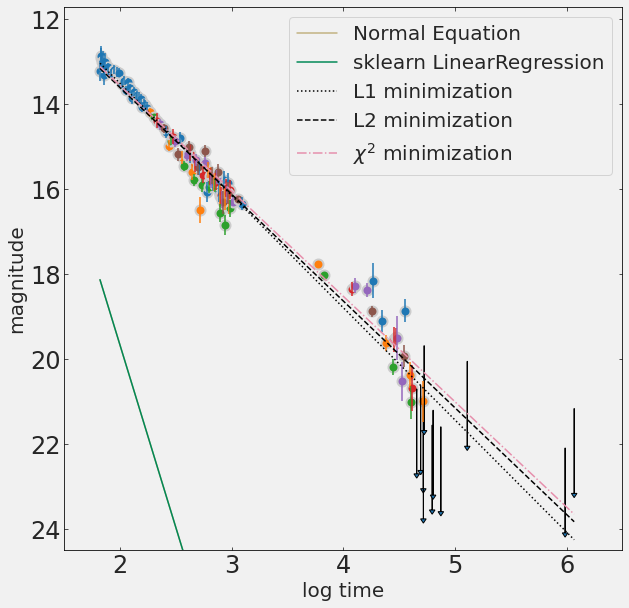

In [89]:
def plotline(pars, x, color='k', symbol='-', label='model', 
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = pl.figure(figsize=(10,10)).add_subplot(111)

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               edgecolor='#cccccc', label=None)
    

# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')
    
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379', 
          '604E97', 'F6A600', 'B3446C', 
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime.values, 
         color='#'+colors[0], 
         label="Normal Equation", ax=ax)
#sklearn
plotline((theta_best[::-1]), grbAG.logtime,  
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,  
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,  
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime, 
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

##Create a table with the results of each method

| method                    | slope    | intercept |
| -----------               |:--------:|----------:|
| Normal Equation           | 2.51     |  8.58     |    
|sklearn.LinearRegression()	| 2.51     |	8.58     |
minimize L1	                |2.64      |	8.23     |
minimize L2	                |2.51      |	8.58     |
minimize chi2	              |2.50      |	8.58     |

##now try a broken power law with MCMC

In [90]:
!pip install emcee

In [91]:
import emcee

In [92]:
emcee

<module 'emcee' from '/usr/local/lib/python3.7/dist-packages/emcee/__init__.py'>

In [93]:
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
     return 0
  return -np.inf

In [94]:
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [95]:
def log_probability(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf

  return lp + log_likelihood(theta, x, y, yerr)


In [96]:
#initial guess
ig = [10, 1]

In [97]:
#initialize walkers
nwalkers = 32
ndim = len(ig)

In [98]:
pos = np.array(ig) + 1e-4 *np.random.randn(nwalkers, ndim)

In [99]:
pos.shape

(32, 2)

In [100]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, s))

In [101]:
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:06<00:00, 769.22it/s]


In [102]:
samples = sampler.get_chain()

In [103]:
samples.shape

(5000, 32, 2)

In [105]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)